In [ ]:
! ls /Users/guillermogonzalez/ga/evan_github/input/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Train Data EDA

In [2]:
train_columns = ['Date',
                 #'Address',
                 'Species',
                 'Block',
                 #'Street',
                 'Trap',
                 #'AddressNumberAndStreet',
                 'Latitude',
                 'Longitude',
                 #'AddressAccuracy',
                 'NumMosquitos',
                 'WnvPresent']

In [3]:
train = pd.read_csv('../input/train.csv',usecols=train_columns)

In [4]:
train['Date'] = pd.to_datetime(train['Date']) # convert dtype to date

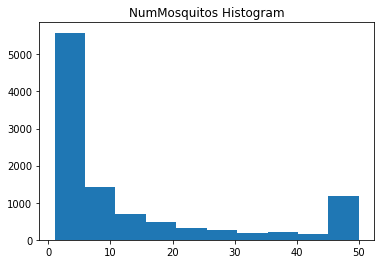

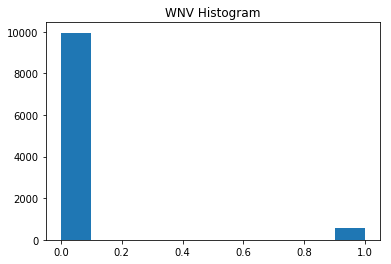

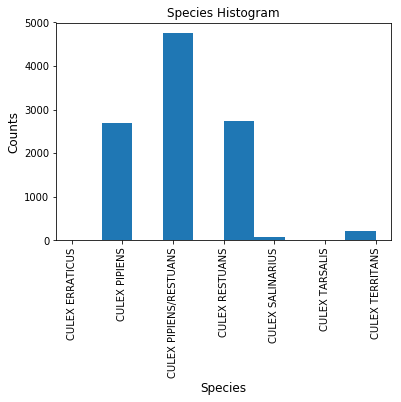

In [5]:
plt.hist(x=train['NumMosquitos'])
plt.title('NumMosquitos Histogram')
plt.show()
plt.hist(x=train['WnvPresent'])
plt.title('WNV Histogram')
plt.show()
plt.hist(x=train['Species'].sort_values(),orientation='vertical')
plt.xticks(x=train['Species'], rotation='vertical')
plt.title('Species Histogram')
plt.xlabel('Species',size='large')
plt.ylabel('Counts',size='large')
plt.show()

### Test Data EDA

In [6]:
test_cols = [#'Id',
             'Date',
             #'Address',
             'Species',
             'Block',
             #'Street',
             'Trap',
             #'AddressNumberAndStreet',
             'Latitude',
             'Longitude',
             #'AddressAccuracy'
            ]

In [7]:
test = pd.read_csv('../input/test.csv',usecols=test_cols)

In [8]:
test['Date'] = pd.to_datetime(test['Date']) # convert date dtype to date

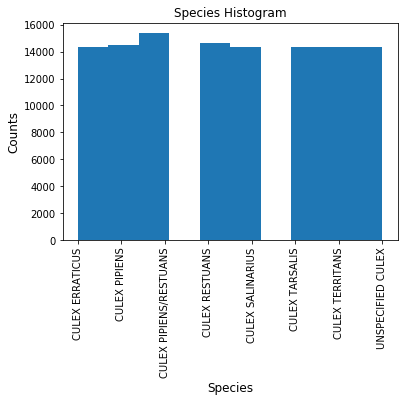

In [9]:
plt.hist(x=test['Species'].sort_values(),orientation='vertical')
plt.xticks(x=test['Species'], rotation='vertical')
plt.title('Species Histogram')
plt.xlabel('Species',size='large')
plt.ylabel('Counts',size='large')
plt.show()

### Weather data EDA

In [10]:
weather_cols = ['Station',
                   'Date',
                   'Tmax',
                   'Tmin',
                   'Tavg',
                   'Depart',
                   'DewPoint',
                   'WetBulb',
                   'Heat',
                   'Cool',
                   'Sunrise',
                   'Sunset',
                   'CodeSum',
                   #'Depth',
                   #'SnowFall',
                   'PrecipTotal',
                   'SeaLevel',
                   'ResultSpeed',
                   'ResultDir',
                   'AvgSpeed'
                  ]

In [11]:
weather = pd.read_csv('../input/weather.csv',
                      usecols=weather_cols,
                      na_values={'Tavg':'M',
                                 'WetBulb':'M',
                                 'Heat':'M',
                                 'Cool':'M',
                                 'Sunrise':'-',
                                 'Sunset':'-',
                                 'PercipTotal':'M',
                                 'Depart':'M'
                                }
                     )

In [12]:
# converting weather codes to one-hot encoded columns
code_list = list(set([i[j] for i in [title.split() for title in pd.get_dummies(weather.CodeSum).columns.tolist()] for j in range(len(i))]))

for code in code_list:
    weather[code] = [1 if code in weather.CodeSum[i] else 0 for i in range(weather.CodeSum.shape[0])]

In [14]:
def stat_fill(df,columns,stat='median'):
    '''
    takes list of column names, changes data type to float and converts null values to a summary stat value.
    '''
    for c in columns:
        try:
            df[c] = df[c].copy().astype(dtype='float') # converts to float
        except:
            print(c,df[c].dtype)
        null_index = df[c][df[c].isnull() == True].index
        print(null_index)
        if stat == 'median':
            df.loc[null_index,c] = [df[c].median() for i in null_index]
        elif stat == 'mean':
            df.loc[null_index,c] = [df[c].mean() for i in null_index]
        else:
            print('Wrong stat!')

def fill_above(df,columns):
    '''
    Takes a null cell's value (from station 2) and fills it with the station 1 value from the same date
    '''
    null_index = df[columns[0]][df[columns[0]].isnull() == True].index
    try:
        for c in columns:
            df.loc[null_index,c] = [df.loc[i - 1,c] if df.loc[i,'Date'] == df.loc[i-1,'Date'] else 0 for i in null_index]
    except:
        print('Oops!')
        pass

In [ ]:
# converts "Trace" percipitation to very small non-zero float
trace_index = weather['PrecipTotal'][weather['PrecipTotal'] == '  T'].index
weather.loc[trace_index,'PrecipTotal'] = [0.001 for i in trace_index] 

stat_fill(weather,['Tavg','WetBulb','Heat','Cool','PrecipTotal']) # convert nulls to median value
stat_fill(weather,['Depart'],stat='mean') # convert nulls to mean departure value
fill_above(weather,['Sunrise','Sunset']) # fills in missing sunrise/sunset time

weather['Date'] = pd.to_datetime(weather['Date']) # convert date dtype to date
weather[['Tavg(C)','DewPoint(C)']]=weather[['Tavg','DewPoint']].apply(lambda x: (x-32)*(5/9)).round(1) # Farenheit to Celcius for RH calculation

#Calculation Relative Humidity
weather['RH'] = (100*(1.8096 + np.exp(17.2694*weather['DewPoint(C)']/(237.3 + weather['DewPoint(C)'])))/
                 (1.8096 + np.exp((17.2694*weather['Tavg(C)']/(237.3 + weather['Tavg(C)']))))).round(1)

In [ ]:
# To do: apply weather data to nearest to trap. add to train data, based on nearest station

In [ ]:
'''
if we don't apply the two stations both, then we can average
'''
# weather.groupby('Date')[['Tmax','Tmin','Tavg','DewPoint','WetBulb','Heat','Cool']].mean().shape

### Spray Data EDA

In [15]:
df_spray = pd.read_csv('../input/spray.csv')

In [16]:
df_spray.nunique()

Date            10
Time          8583
Latitude     12887
Longitude    13007
dtype: int64

In [ ]:
columns_spray = df_spray.columns
for col in columns_spray:
    print(col)
    print(df_spray[col].value_counts())

In [ ]:
df_spray.isnull().sum()

In [ ]:
spray = df_spray.copy()

In [ ]:
spray['Time']

### Sample Submission data EDA

In [ ]:
df_sample = pd.read_csv('/Users/guillermogonzalez/ga/evan_github/input/sampleSubmission.csv')

In [ ]:
df_sample.nunique()

### Date Ranges

In [ ]:
print('          Min          Max')
print('train =  ',df_train['Date'].min(),' ', df_train['Date'].max())
print('test =   ',df_test['Date'].min(),' ', df_test['Date'].max())
print('weather =',df_weather['Date'].min(),' ', df_weather['Date'].max())
print('spray =  ',df_spray['Date'].min(),' ', df_spray['Date'].max())